Author: Ani Aggarwal  
Github: www.github.com/AniAggarwal
# Outline

1. Down sample
2. Bandpass filter
3. Normalization
4. DWT
5. Refilter using LPF
6. Envelope Detection
7. Peak Identification
8. Extra peak rejection
9. If std is of even or odd intervals <= 100, continue, else repeat from 7
10. Locate S1 and S2
11. Feature engineering
12. Data normalization
13. Balance datasets
13. Split into train, validation, and test
14. Shuffle data
15. Train model
16. Test model

# Preprocessing

## Constants

In [7]:
DOWN_SR = 1000
BPF_LOW = 20
BPF_HIGH = 400
BPF_ORDER = 3

AUDIO_LEN = 5  # in seconds
num_samples = AUDIO_LEN * DOWN_SR

## Experiments

In [71]:
import librosa
import librosa.display

from scipy.signal import butter, lfilter
import numpy as np
import sklearn
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path
import csv
import json

import IPython.display as ipd

In [3]:
train_path = Path("./datasets/classification-heart-sounds-physionet/training-a")
audio_path = train_path / "a0001.wav"

In [4]:
audio, _ = librosa.load(audio_path, sr=DOWN_SR)

In [5]:
ipd.Audio(audio_path)

<Figure size 2880x720 with 0 Axes>

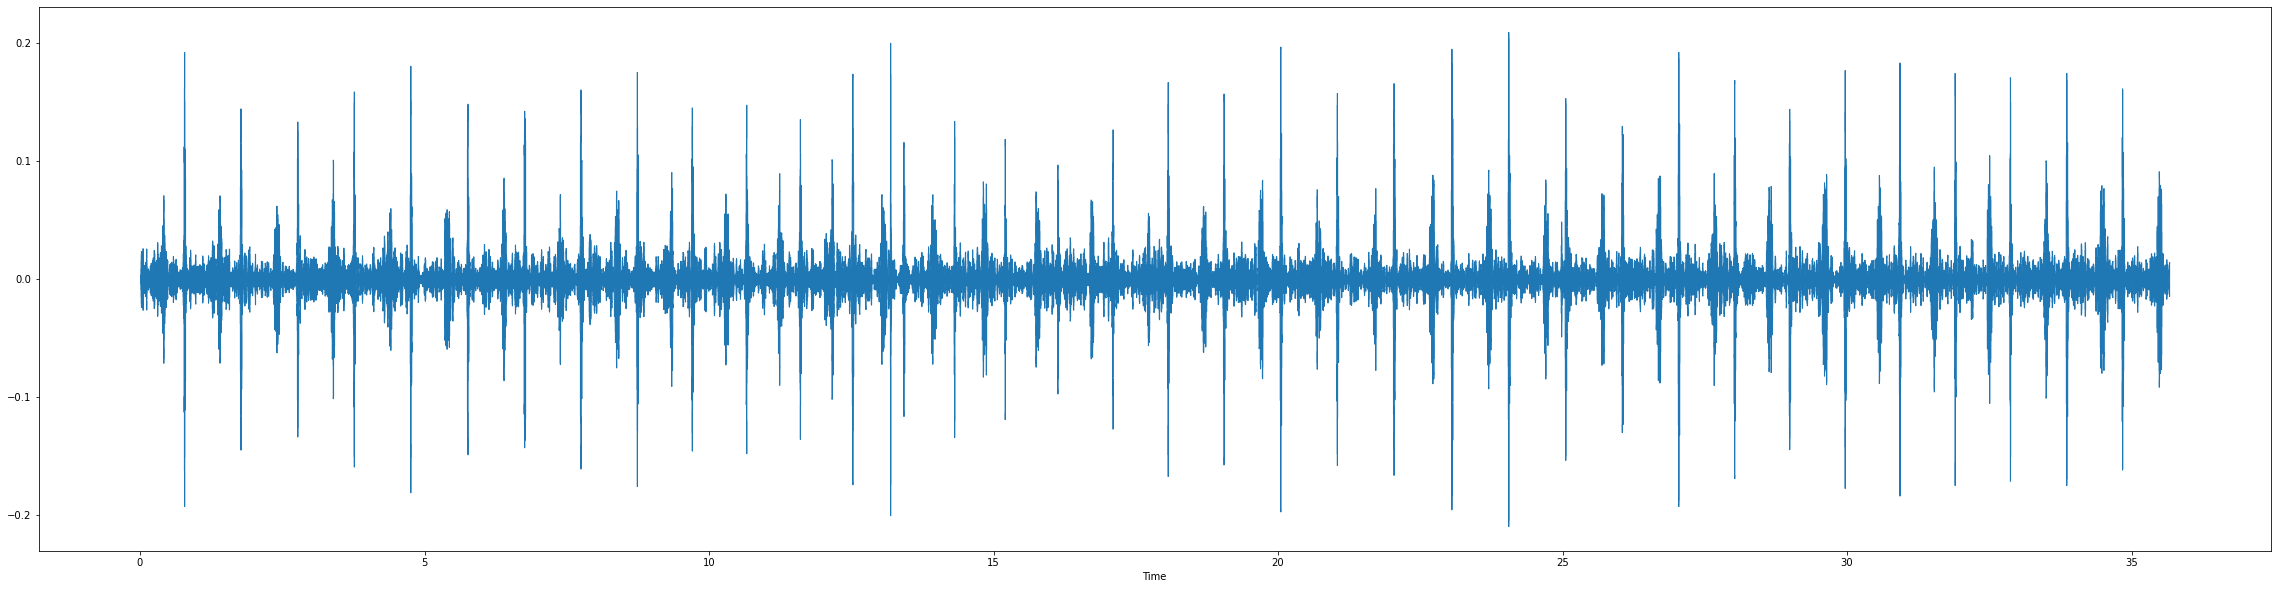

In [6]:
plt.figure(figsize=(40, 10))
librosa.display.waveshow(audio, sr=DOWN_SR)

<Figure size 2880x720 with 0 Axes>

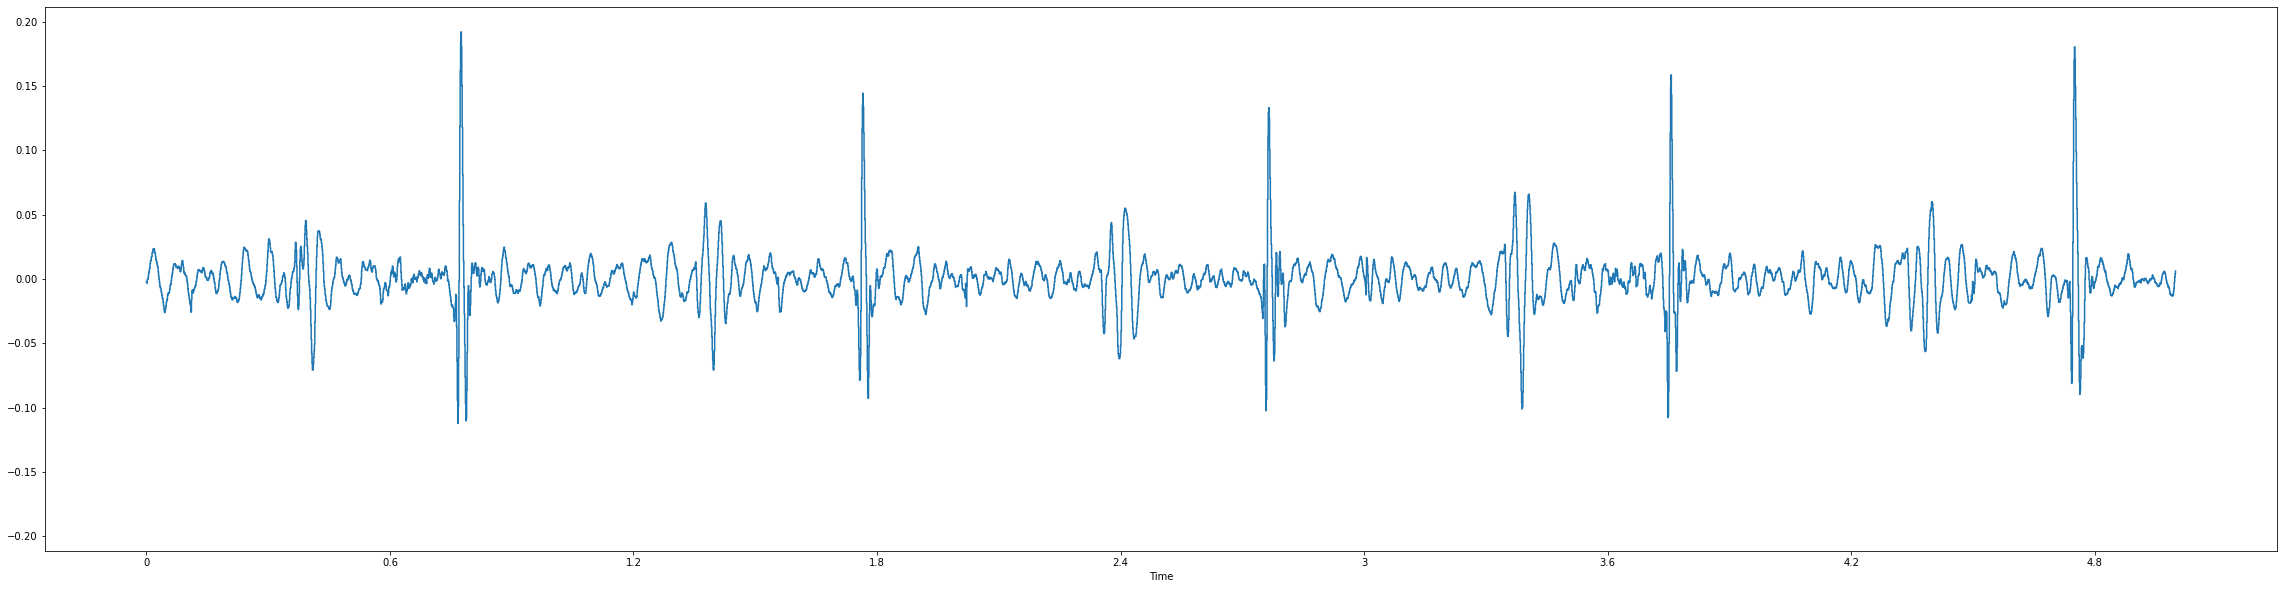

In [8]:
audio_short = audio[:num_samples]
plt.figure(figsize=(40, 10))
librosa.display.waveshow(audio_short, sr=DOWN_SR)

## Band Pass Filter

In [9]:
# from https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

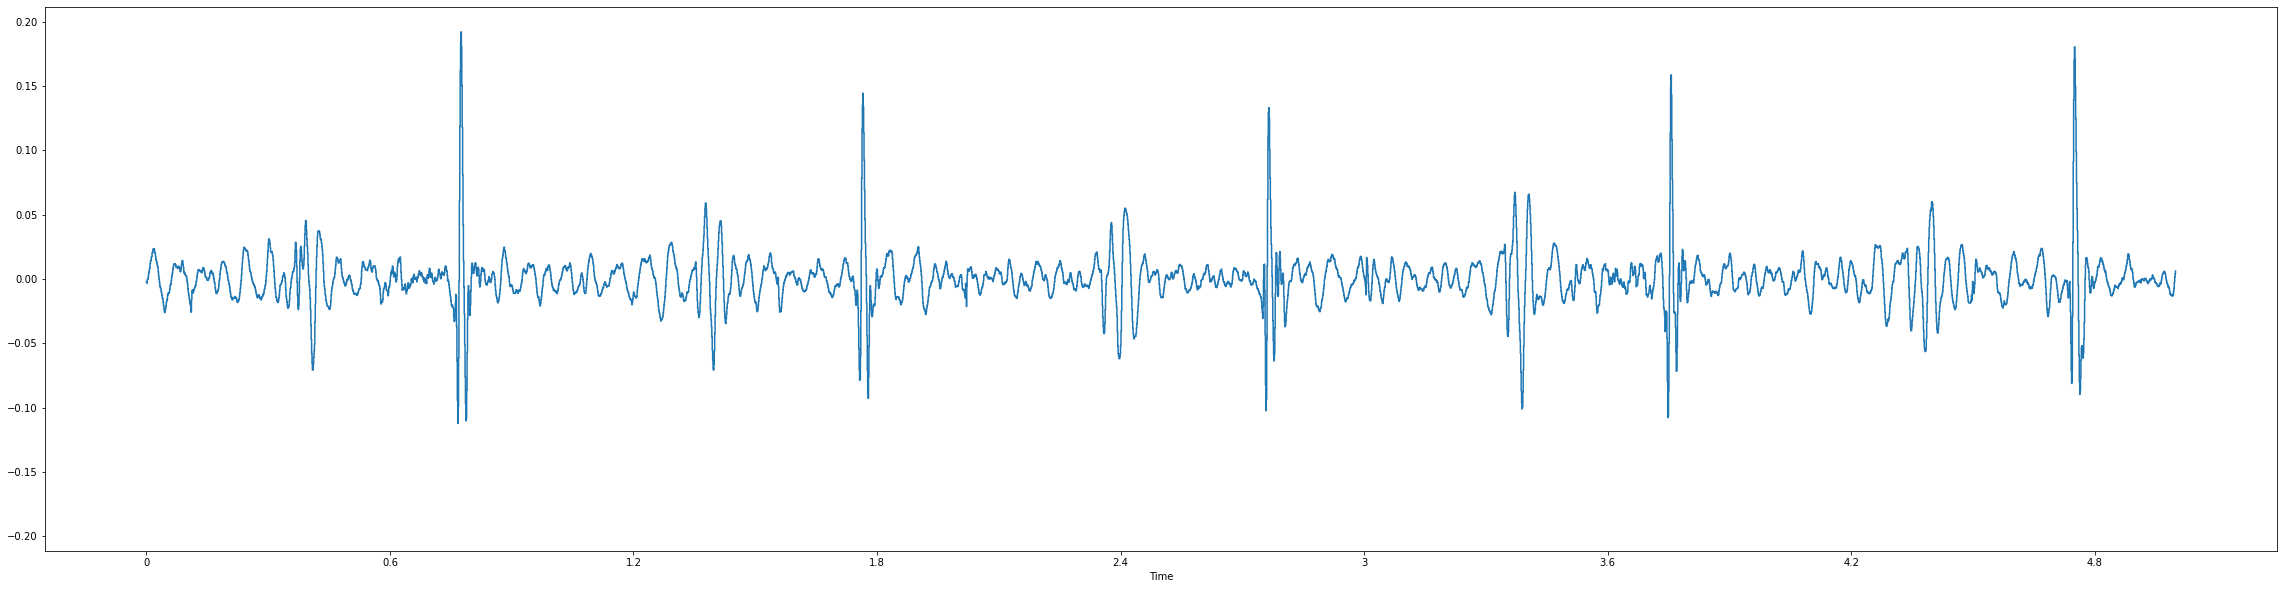

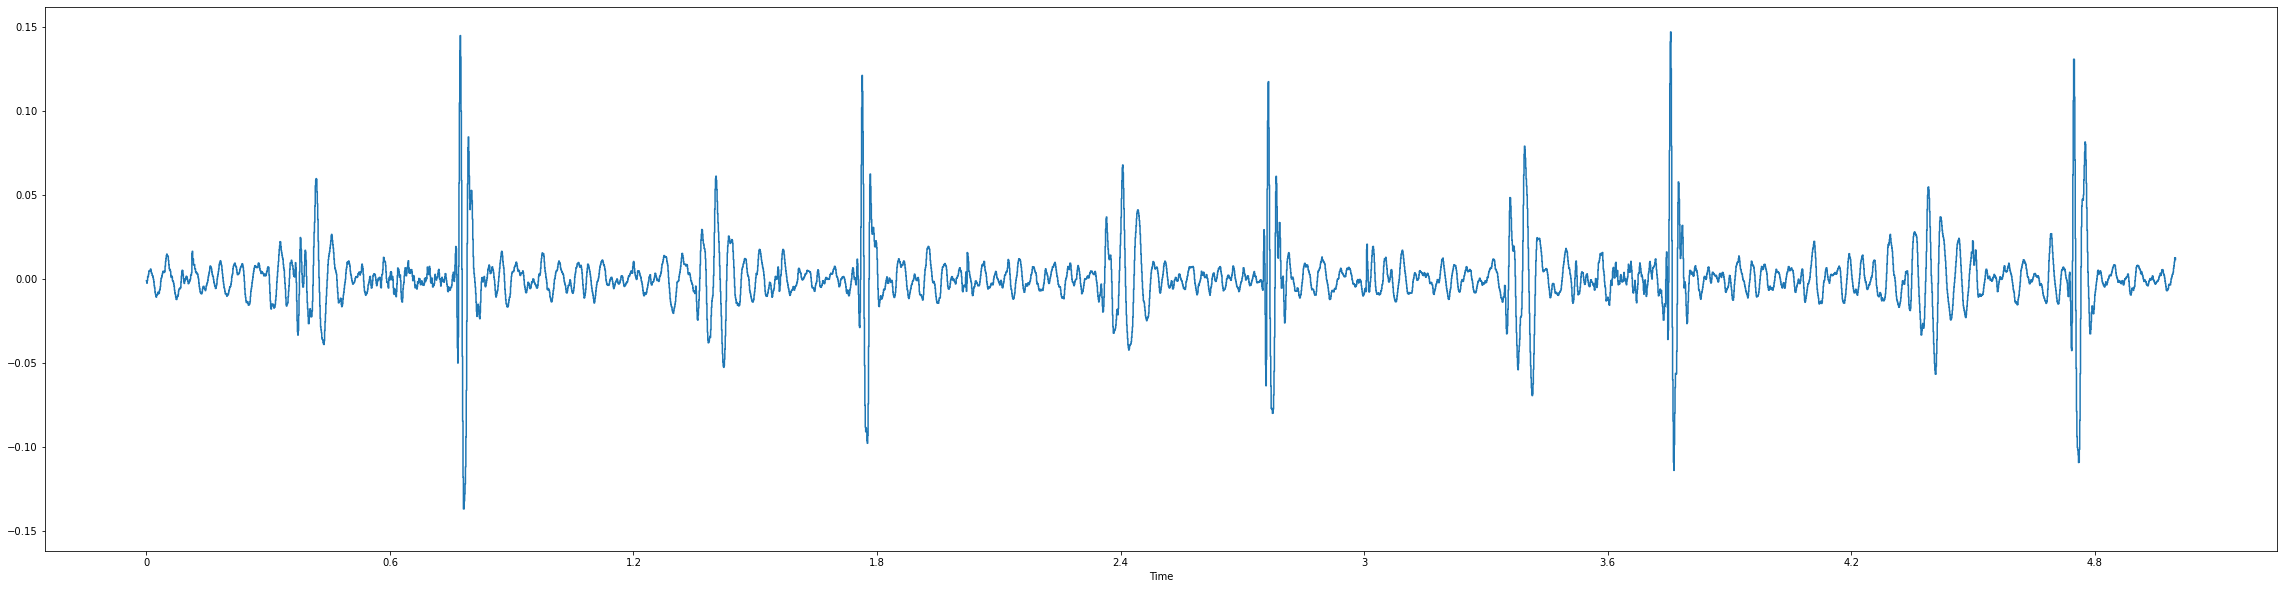

In [10]:
plt.figure(figsize=(40, 10))
librosa.display.waveshow(audio_short, sr=DOWN_SR)

audio_short = butter_bandpass_filter(audio_short, BPF_LOW, BPF_HIGH, DOWN_SR, order=BPF_ORDER)
plt.figure(figsize=(40, 10))
librosa.display.waveshow(audio_short, sr=DOWN_SR)

## Normalization

Normalizing data between -1.0 and 1.0

In [11]:
audio_short.max(), audio_short.min()
audio_short = 2 * (audio_short - audio_short.min()) / (audio_short.max() - audio_short.min()) - 1.0

audio_short.max(), audio_short.min()

(0.14712397279625522, -0.13690797092181306)

(1.0, -1.0)

<Figure size 2880x720 with 0 Axes>

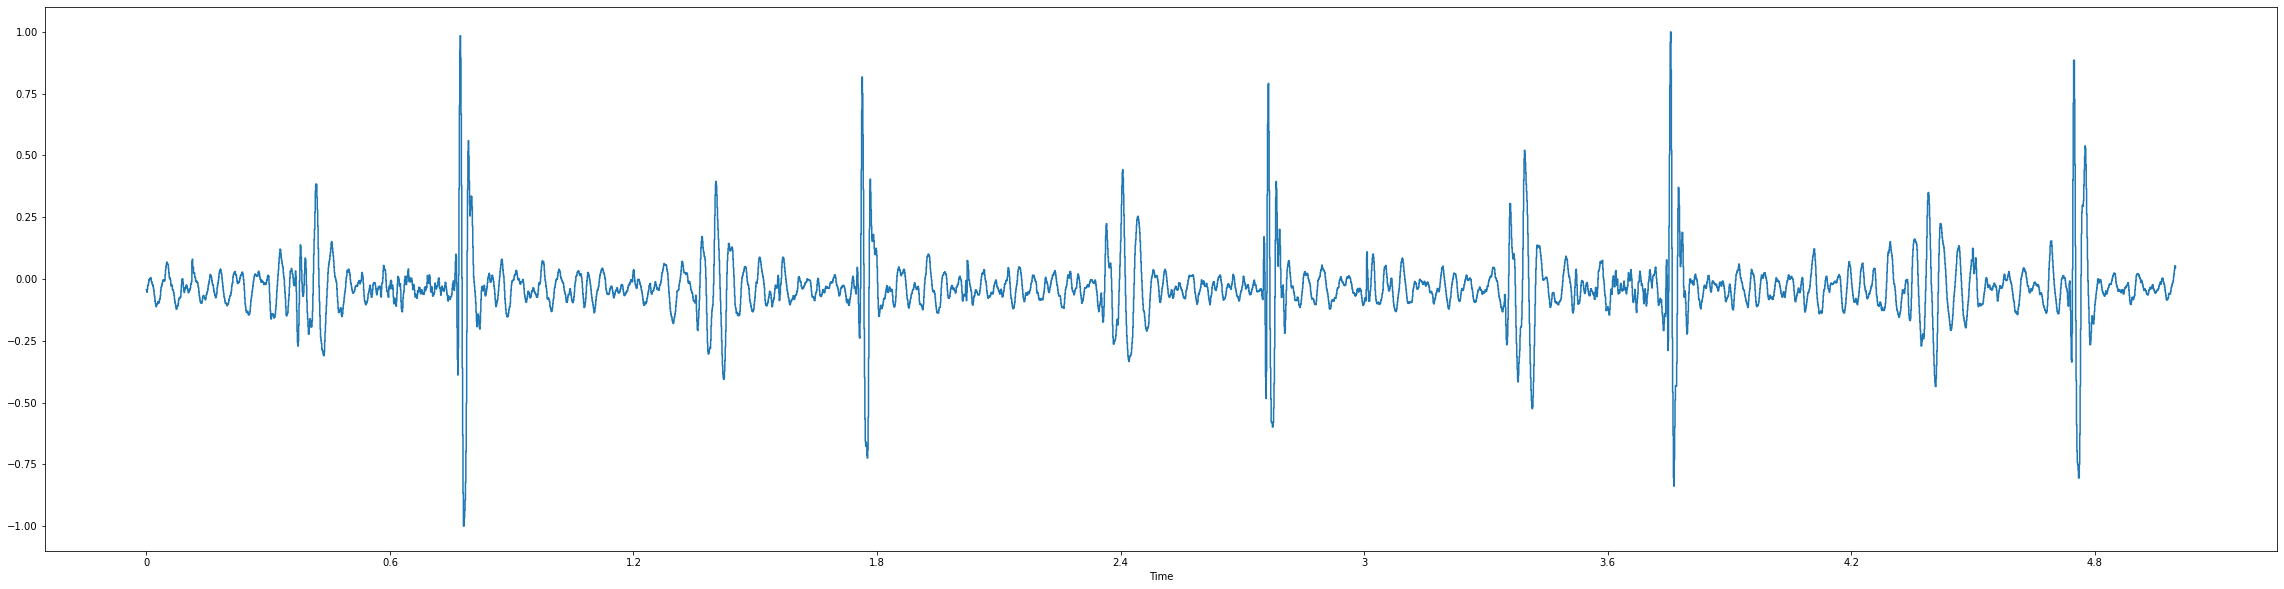

In [12]:
plt.figure(figsize=(40, 10))
librosa.display.waveshow(audio_short, sr=DOWN_SR)

## Spectogram

<Figure size 2880x720 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Frequency')

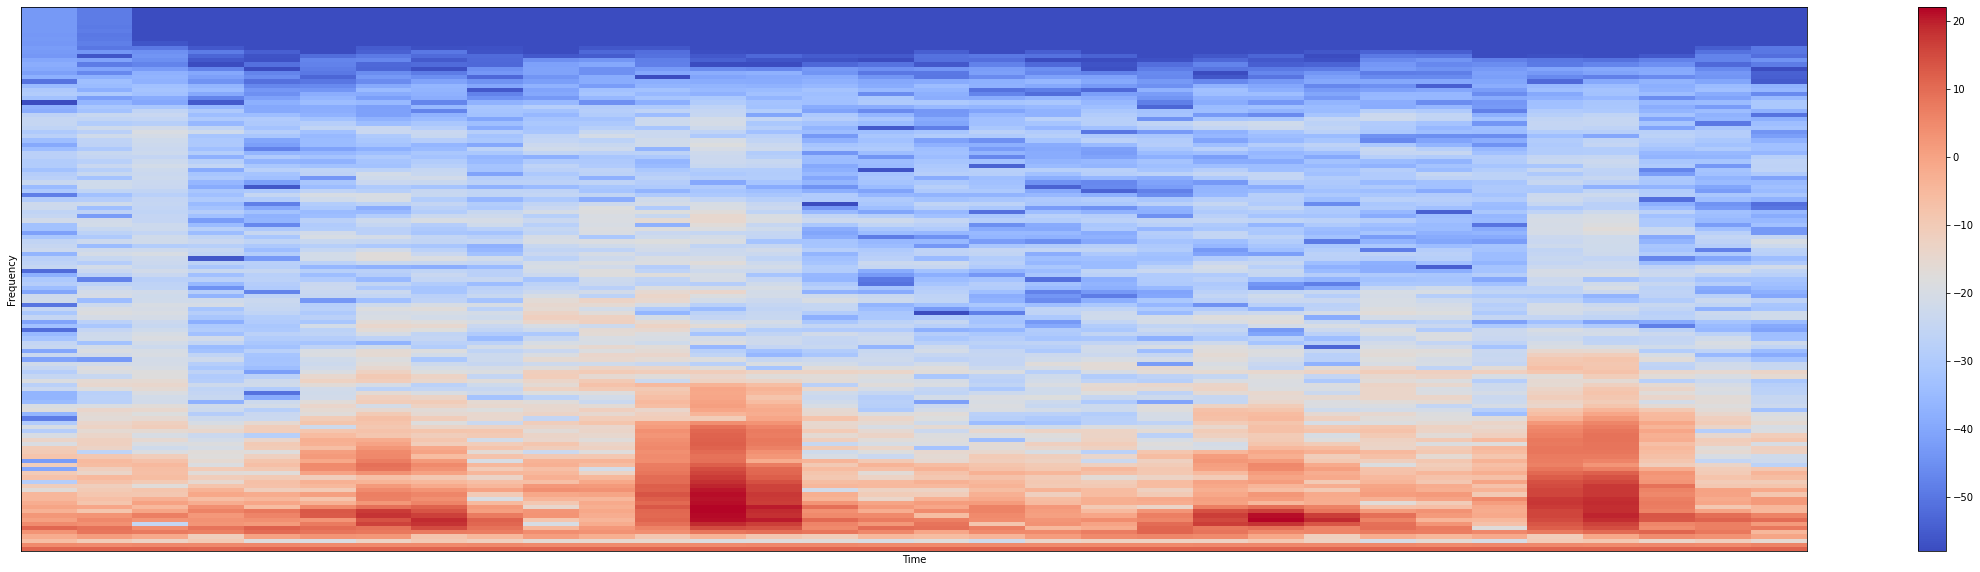

In [22]:
n_fft = 256
hop_len = 64
stft = librosa.core.stft(audio_short, n_fft=n_fft, hop_length=hop_len)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(40, 10))
librosa.display.specshow(log_spectrogram, sr=DOWN_SR, hop_length=hop_len)
plt.colorbar()

plt.xlabel("Time")
plt.ylabel("Frequency")

# Feature Selection using MFCC

25ms window + 10ms step size + 13 coeffs

In [19]:
n_fft = int(0.025 * DOWN_SR)
hop_len = int(0.01 * DOWN_SR)
n_mfcc = 13

n_fft
hop_len

25

10

<Figure size 2880x720 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'MFCC')

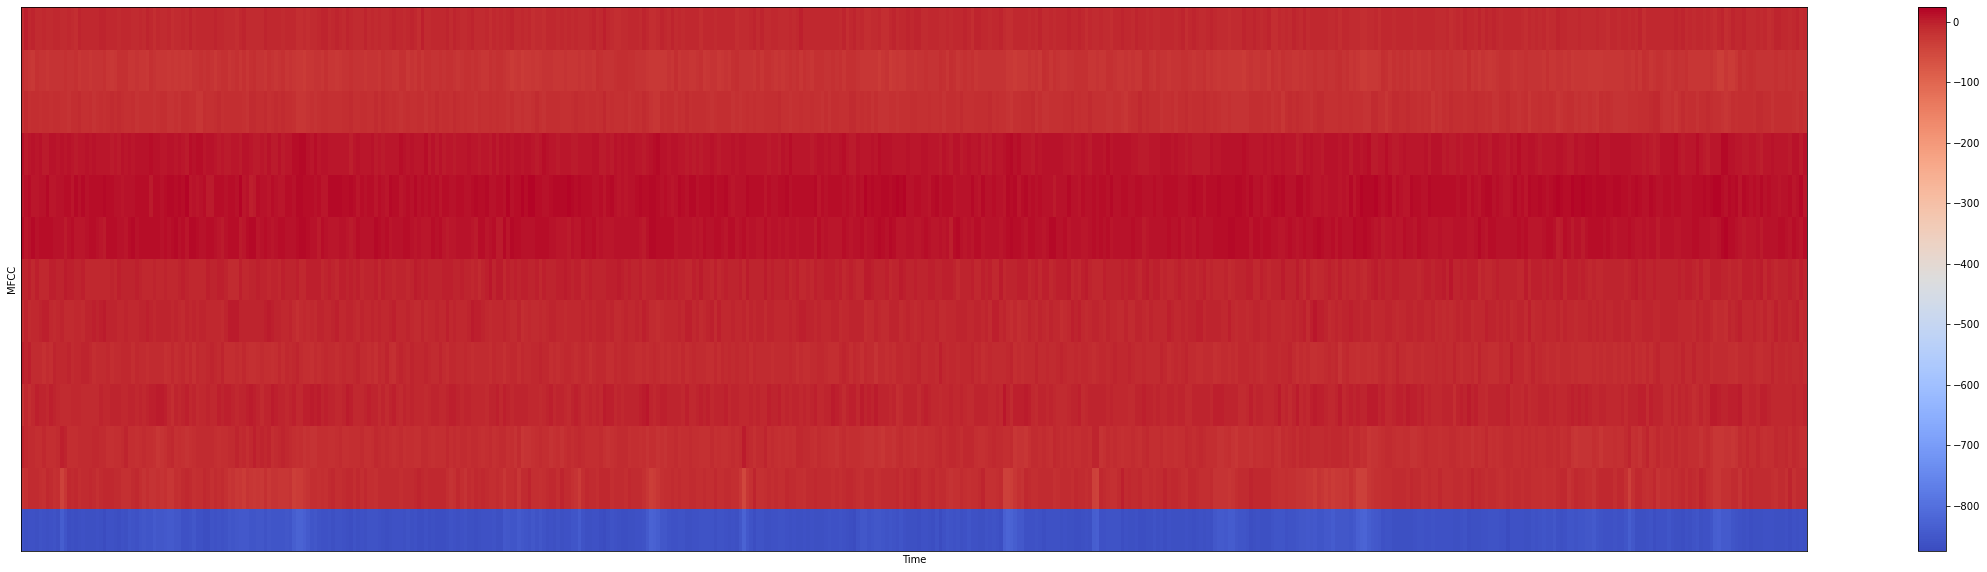

In [20]:
mfccs = librosa.feature.mfcc(audio_short, n_fft=n_fft, hop_length=hop_len, n_mfcc=n_mfcc)

plt.figure(figsize=(40, 10))
librosa.display.specshow(mfccs, sr=DOWN_SR, hop_length=hop_len)

plt.colorbar()
plt.xlabel("Time")
plt.ylabel("MFCC")

In [21]:
mfccs.shape

(13, 500)

# Making the dataset

RECORDS file contains names of all recordings.  
REFERENCE.csv contains names of recordings and classification.  

**-1 is normal, 1 is abnormal**

In [ ]:
def proccess_audio_file(audio_path):
    

In [28]:
datasets_path = Path("./datasets/classification-heart-sounds-physionet/")

data = {
    "mfccs": [],
    "labels": []
}


for dataset_path in datasets_path.iterdir():
    if "training-" in dataset_path.name:
        with open(dataset_path / "REFERENCE.csv", "r") as f:
            csv_reader = csv.reader(f)
            for file_name, label in csv_reader:
                

datasets\classification-heart-sounds-physionet\training-a
datasets\classification-heart-sounds-physionet\training-b
datasets\classification-heart-sounds-physionet\training-c
datasets\classification-heart-sounds-physionet\training-d
datasets\classification-heart-sounds-physionet\training-e
datasets\classification-heart-sounds-physionet\training-f


In [45]:
sum([1 for i in np.split(audio[:len(audio) - (len(audio) % 10)], 10) if i.size == 0])

0

In [47]:
x = np.arange(10)

In [49]:
np.split(x[:len(x) - (len(x) % 11)], 11)

[array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32)]

In [66]:
num_samples = int((audio.size / DOWN_SR) // 5)
shortened = np.split(audio[:len(audio) - (len(audio) % num_samples)], num_samples)

In [67]:
shortened[0].shape

(5095,)

# Train Model Testing

In [65]:
import json
from pathlib import Path

import numpy as np
from sklearn.model_selection import train_test_split


def load_data(dataset_path):
    with open(dataset_path, "r") as f:
        data = json.load(f)

    # convert lists back to np arrays
    X = np.array(data["mfccs"])
    y = np.array(data["labels"])
    # shapes: X (13015, 500, 13), y (13015,)

    print(f"Data loaded. X shape: {X.shape}, y shape: {y.shape}")
    return X, y


def unison_shuffled_copies(a, b):
    # from https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def process_data(X, y):
    # convert to 1 for abnormal and 0 for normal
    y[y == -1] = 0

    # shuffle data
    print("Shuffling data")
    X, y = unison_shuffled_copies(X, y)
    print(f"Data shuffled. X shape: {X.shape}, y shape: {y.shape}")

    # balance data
    # actual counts: abnormal: 3158, normal: 9857
    num_abnormal, num_normal = np.count_nonzero(y == 1), np.count_nonzero(y == 0)
    print(
        f"Balancing data. Before count abnormal: {num_abnormal}, normal: {num_normal}"
    )

    if num_abnormal > num_normal:
        # select few from abnormals
        X = np.concatenate([X[y == 0][:num_normal], X[y == 0]])
        y = np.concatenate([y[y == 0][:num_normal], y[y == 0]])
    else:
        # select few from normals
        X = np.concatenate([X[y == 0][:num_abnormal], X[y == 1]])
        y = np.concatenate([y[y == 0][:num_abnormal], y[y == 1]])

    print(
        f"After count abnormal: {np.count_nonzero(y == 1)}, normal: {np.count_nonzero(y == 0)}"
    )

    # split data
    return train_test_split(X, y, test_size=0.15)

In [63]:
json_path = Path("./datasets/data.json")
np_path = Path("./datasets/")

In [64]:
print("Loading data from", str(json_path))
X, y = load_data(json_path)

Loading data from datasets\data.json
Data loaded. X shape: (13015, 500, 13), y shape: (13015,)


In [66]:
X_train, X_test, y_train, y_test = process_data(X, y)

Shuffling data
Data shuffled. X shape: (13015, 500, 13), y shape: (13015,)
Balancing data. Before count abnormal: 3158, normal: 9857
After count abnormal: 3158, normal: 3158


In [67]:
np.save(np_path / "X_train", X_train)
np.save(np_path / "y_train", y_train)
np.save(np_path / "X_test", X_test)
np.save(np_path / "y_test", y_test)

print("Data saved to", str(np_path))

Data saved to datasets


# Prediction

In [1]:
from pathlib import Path

import tensorflow.keras as keras
import numpy as np
import librosa

from create_dataset import process_audio_np, denoise_audio_np


class Inference:
    def __init__(self, model_path, sample_rate):
        self.model = keras.models.load_model(model_path)
        self.sample_rate = sample_rate

        self.model.summary()

    def predict(self, byte_list, threshold=0.05):
        # TODO figure out why x shape first dim is double what it should be
        #  (ex: 35 sec clip divided into 5 sec clips produces 14 in first dim)
        x = self.preprocess(byte_list)
        print("x shape", x.shape)

        pred = self.model.predict_on_batch(x)
        print("pred shape", pred.shape)
        print(pred)
        pred = pred[0]
        if 0.5 - threshold <= pred <= 0.5 + threshold:
            return "unsure"
        if pred > 0.5:
            return "abnormal"
        return "normal"

    def preprocess(self, byte_list):
        audio = np.array(byte_list)
        audio = librosa.resample(audio, self.sample_rate, 1000)
        mfccs = process_audio_np(audio, 5)  # 5 second samples
        return np.array(mfccs)

    def get_wav(self, byte_list):
        audio = np.array(byte_list)
        audio = librosa.resample(audio, self.sample_rate, 1000)
        audio = denoise_audio_np(audio)
        # librosa.output.write_wav

In [2]:
model_full_save = Path(
    "./model_saves/3515192_epochs_15-batch_size_2-lr_1e-06/full_save"
)
test_audio_path = Path(
    "./datasets/classification-heart-sounds-physionet/training-a/a0001.wav"
)

In [3]:
inference = Inference(model_full_save, 1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 500, 128)          39936     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 64)           41216     
_________________________________________________________________
dense (Dense)                (None, 500, 16)           1040      
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 16)           64        
_________________________________________________________________
re_lu (ReLU)                 (None, 500, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 16)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 500, 1)            1

In [7]:
for layer in inference.model.layers:
    print(layer.get_input_at(0).get_shape().as_list())
    print(layer.get_output_at(0).get_shape().as_list(), "\n")

[None, 500, 13]
[None, 500, 128] 

[None, 500, 128]
[None, 500, 64] 

[None, 500, 64]
[None, 500, 16] 

[None, 500, 16]
[None, 500, 16] 

[None, 500, 16]
[None, 500, 16] 

[None, 500, 16]
[None, 500, 16] 

[None, 500, 16]
[None, 500, 1] 



In [ ]:
audio_np, sr = librosa.load(test_audio_path, sr=None)
print(inference.predict(audio_np))